In [1]:
# Setting up a model and a mesh for the MT forward problem

In [3]:
import SimPEG as simpeg, sys
import numpy as np
from SimPEG import NSEM
import telluricpy
import matplotlib.pyplot as plt
%matplotlib inline
import copy

In [4]:
# Define the area of interest
bw, be = 557100, 557580
bs, bn = 7133340, 7133960
bb, bt = 0,480

# Build the mesh
# Design the tensors
hSize,vSize =  25., 10
nrCcore = [15, 8, 6, 5, 4, 2, 2, 2, 2]
hPad = simpeg.Utils.meshTensor([(hSize,10,1.5)])
hx = np.concatenate((hPad[::-1],np.ones(((be-bw)/hSize,))*hSize,hPad))
hy = np.concatenate((hPad[::-1],np.ones(((bn-bs)/hSize,))*hSize,hPad))
airPad = simpeg.Utils.meshTensor([(vSize,13,1.5)])
vCore = np.concatenate([ np.ones(i)*s for i, s in zip(nrCcore,(simpeg.Utils.meshTensor([(vSize,1),(vSize,8,1.3)])))])[::-1]
botPad = simpeg.Utils.meshTensor([(vCore[0],8,-1.5)])
hz = np.concatenate((botPad,vCore,airPad))
# Calculate the x0 point
x0 = np.array([bw-np.sum(hPad),bs-np.sum(hPad),bt-np.sum(vCore)-np.sum(botPad)])
# Make the mesh
meshFor = simpeg.Mesh.TensorMesh([hx,hy,hz],x0)


In [28]:
# Build the Inversion mesh
# Design the tensors
hSizeI,vSizeI =  25., 10.
nrCcoreI = [12, 6, 4, 4, 3, 3, 3, 2, 1]
hPadI = simpeg.Utils.meshTensor([(hSizeI,10,1.75)])
hxI = np.concatenate((hPadI[::-1],np.ones(((be-bw)/hSizeI,))*hSizeI,hPadI))
hyI = np.concatenate((hPadI[::-1],np.ones(((bn-bs)/hSizeI,))*hSizeI,hPadI))
airPadI = simpeg.Utils.meshTensor([(vSizeI,12,1.75)])
vCoreI = np.concatenate([ np.ones(i)*s for i, s in zip(nrCcoreI,(simpeg.Utils.meshTensor([(vSizeI,1),(vSizeI,8,1.3)])))])[::-1]
botPadI = simpeg.Utils.meshTensor([(vCoreI[0],8,-1.75)])
hzI = np.concatenate((botPadI,vCoreI,airPadI))
# Calculate the x0 point
x0I = np.array([bw-np.sum(hPadI),bs-np.sum(hPadI),bt-np.sum(vCoreI)-np.sum(botPadI)])
# Make the mesh
meshInv = simpeg.Mesh.TensorMesh([hxI,hyI,hzI],x0I)
meshFor = copy.deepcopy(meshInv)

In [29]:
NSEM.Utils.skindepth(1e2,10)

1591.5494309189532

In [30]:
print np.sum(vCoreI)
print np.sum(hPadI)
print np.sum(airPadI), np.sum(botPadI)
print meshFor.nC
print meshFor

902.4252761
15656.0477495
19226.7834932 16552.4591234
99528
  ---- 3-D TensorMesh ----  
   x0: 541443.95
   y0: 7117683.95
   z0: -16974.88
  nCx: 39
  nCy: 44
  nCz: 58
   hx: 6734.73, 3848.42, 2199.10, 1256.63, 718.07, 410.33, 234.47, 133.98, 76.56, 43.75, 19*25.00, 43.75, 76.56, 133.98, 234.47, 410.33, 718.07, 1256.63, 2199.10, 3848.42, 6734.73
   hy: 6734.73, 3848.42, 2199.10, 1256.63, 718.07, 410.33, 234.47, 133.98, 76.56, 43.75, 24*25.00, 43.75, 76.56, 133.98, 234.47, 410.33, 718.07, 1256.63, 2199.10, 3848.42, 6734.73
   hz: 7175.48, 4100.28, 2343.02, 1338.87, 765.07, 437.18, 249.82, 142.75, 81.57, 2*62.75, 3*48.27, 3*37.13, 3*28.56, 4*21.97, 4*16.90, 6*13.00, 12*10.00, 17.50, 30.62, 53.59, 93.79, 164.13, 287.23, 502.65, 879.64, 1539.37, 2693.89, 4714.31, 8250.05


In [31]:
# Save the mesh
meshFor.writeVTK('nsmesh_GKRcoarse.vtr',{'id':np.arange(meshFor.nC)})
nsvtr = telluricpy.vtkTools.io.readVTRFile('nsmesh_GKRcoarse.vtr')

In [32]:
nsvtr

(vtkRectilinearGrid)0x7f5b5a780050

In [33]:
topoSurf = telluricpy.vtkTools.polydata.normFilter(telluricpy.vtkTools.io.readVTPFile('../../Geological_model/CDED_Lake_Coarse.vtp'))
activeMod = telluricpy.vtkTools.extraction.extractDataSetWithPolygon(nsvtr,topoSurf)

In [34]:
topoSurf

(vtkPolyData)0x7f5b5a7800b0

In [35]:
#telluricpy.vtkTools.io.writeVTUFile('activeModel.vtu',activeMod)

In [36]:
# Get active indieces 
activeInd = telluricpy.vtkTools.dataset.getDataArray(activeMod,'id')

In [37]:
# Make the conductivity dictionary
# Note: using the background value for the till, since the extraction gets the ind's below the till surface
geoStructFileDict = {'Till':1e-4,
 'PK1':5e-2,
 'HK1':1e-3,
  'VK':5e-3}

In [38]:
# Loop through
extP = '../../Geological_model/'
geoStructIndDict = {}
for key, val in geoStructFileDict.iteritems():
    geoPoly = telluricpy.vtkTools.polydata.normFilter(telluricpy.vtkTools.io.readVTPFile(extP+key+'.vtp'))
    modStruct = telluricpy.vtkTools.extraction.extractDataSetWithPolygon(activeMod,geoPoly,extBoundaryCells=True,extInside=True,extractBounds=True)
    geoStructIndDict[key] = telluricpy.vtkTools.dataset.getDataArray(modStruct,'id')

In [39]:
# Make the physical prop
sigma = np.ones(meshFor.nC)*1e-8
sigma[activeInd] = 1e-3 # 1e-4 is the background and 1e-3 is the till value
# Add the structure
for key in ['Till','PK1','HK1','VK']:
    sigma[geoStructIndDict[key]] = geoStructFileDict[key]

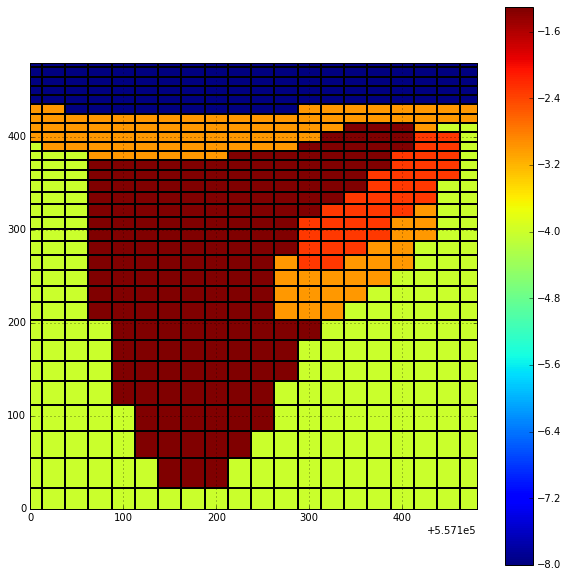

In [40]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
model = sigma.reshape(meshFor.vnC,order='F')
a = ax.pcolormesh(meshFor.gridCC[:,0].reshape(meshFor.vnC,order='F')[:,20,:],meshFor.gridCC[:,2].reshape(meshFor.vnC,order='F')[:,20,:],np.log10(model[:,20,:]),edgecolor='k')

ax.set_xlim([bw,be])
ax.set_ylim([-0,bt])
ax.grid(which="major")
plt.colorbar(a)
ax.set_aspect("equal")

In [41]:
# Save the model
meshFor.writeVTK('nsmesh_GKRCoarseHKPK1.vtr',{'S/m':sigma})

In [89]:
import numpy as np

In [44]:
# Set up the forward modeling
freq = np.logspace(5,0,31)
np.save('MTfrequencies',freq)

In [45]:
freq

array([  1.00000000e+05,   6.81292069e+04,   4.64158883e+04,
         3.16227766e+04,   2.15443469e+04,   1.46779927e+04,
         1.00000000e+04,   6.81292069e+03,   4.64158883e+03,
         3.16227766e+03,   2.15443469e+03,   1.46779927e+03,
         1.00000000e+03,   6.81292069e+02,   4.64158883e+02,
         3.16227766e+02,   2.15443469e+02,   1.46779927e+02,
         1.00000000e+02,   6.81292069e+01,   4.64158883e+01,
         3.16227766e+01,   2.15443469e+01,   1.46779927e+01,
         1.00000000e+01,   6.81292069e+00,   4.64158883e+00,
         3.16227766e+00,   2.15443469e+00,   1.46779927e+00,
         1.00000000e+00])

In [92]:
# Find the locations on the surface of the model.
# Get the outer shell of the model
import vtk
actModVTP = telluricpy.vtkTools.polydata.normFilter(telluricpy.vtkTools.extraction.geometryFilt(activeMod))
polyBox = vtk.vtkCubeSource()
polyBox.SetBounds(bw-5.,be+5,bs-5.,bn+5.,bb-5.,bt+5)
polyBox.Update()
# Exract the topo of the model
modTopoVTP = telluricpy.vtkTools.extraction.extractDataSetWithPolygon(actModVTP,telluricpy.vtkTools.polydata.normFilter(polyBox.GetOutput()),extractBounds=False)
telluricpy.vtkTools.io.writeVTPFile('topoSurf.vtp',actModVTP)

In [93]:
# Make the rxLocations file
x,y = np.meshgrid(np.arange(bw+12.5,be,25),np.arange(bs+12.5,bn,25))
xy = np.hstack((x.reshape(-1,1),y.reshape(-1,1)))
# Find the location array
locArr = telluricpy.modelTools.surfaceIntersect.findZofXYOnPolydata(xy,actModVTP) #modTopoVTP)
np.save('MTlocations',locArr)

In [94]:
telluricpy.vtkTools.io.writeVTPFile('MTloc.vtp',telluricpy.dataFiles.XYZtools.makeCylinderPtsVTP(locArr,5,10,10))

In [95]:
# Running the forward modelling on the Cluster.
# Define the forward run in findDiam_MTforward.py

In [57]:
%matplotlib qt
#sys.path.append('/home/gudni/Dropbox/code/python/MTview/')
import interactivePlotFunctions as iPf

ImportError: No module named interactivePlotFunctions

In [60]:
# Load the data
mtData = np.load('MTdataStArr_nsmesh_HKPK1Coarse_noExtension.npy')
mtData

array([ (100000.0, 557112.5, 7133352.5, 430.0, (-1.0542164193648105-1.078716532478167j), (-23.140299596973666-19.826260505391872j), (23.389975746284172+16.906399777383363j), (0.8754499581492817+0.9556685008070969j), (-0.014494125205579434-0.07954239614803678j), (-0.041490314794175386-0.03416351101035116j)),
       (100000.0, 557137.5, 7133352.5, 430.0, (-0.8021625305031573-1.0706053468599814j), (-22.468510894286695-20.396746977494697j), (21.559482953002853+16.879166721314032j), (0.7266645327124629+1.013308657415905j), (-0.026078011261232766-0.06460099808114624j), (-0.05167463997663666-0.045362677468930454j)),
       (100000.0, 557162.5, 7133352.5, 430.0, (-1.2769734094735785-1.5464705772315357j), (-21.490658131993406-20.50650121756002j), (19.940463496713754+16.6686274356102j), (1.4318914664525015+1.704947597305036j), (-0.03226267161532167-0.0512420800212148j), (-0.06230127502660536-0.058274513337287906j)),
       ...,
       (1000.0, 557512.5, 7133952.5, 440.0, (1.197916611440613+0.645

NameError: name 'rxT' is not defined

In [110]:
iPf.MTinteractiveMap([mtData])

In [104]:
# Looking at the data shows that data below 100Hz is affected by the boundary conditions, 
# which makes sense for very conductive conditions as we have.
# Invert data in the 1e5-1e2 range.

Run the inversion on the cluster using the inv3d/run1/findDiam_inversion.py

In [106]:
drecAll = np.load('MTdataStArr_nsmesh_0.npy')

In [109]:
np.unique(drecAll['freq'])[10::]

array([    100.        ,     158.48931925,     251.18864315,
           398.10717055,     630.95734448,    1000.        ,
          1584.89319246,    2511.88643151,    3981.07170553,
          6309.5734448 ,   10000.        ,   15848.93192461,
         25118.8643151 ,   39810.71705535,   63095.73444802,  100000.        ])

In [93]:
# Build the Inversion mesh
# Design the tensors
hSizeI,vSizeI =  25., 10.
nrCcoreI = [12, 6, 6, 6, 5, 4, 3, 2, 1]
hPadI = simpeg.Utils.meshTensor([(hSizeI,9,1.5)])
hxI = np.concatenate((hPadI[::-1],np.ones(((be-bw)/hSizeI,))*hSizeI,hPadI))
hyI = np.concatenate((hPadI[::-1],np.ones(((bn-bs)/hSizeI,))*hSizeI,hPadI))
airPadI = simpeg.Utils.meshTensor([(vSizeI,12,1.5)])
vCoreI = np.concatenate([ np.ones(i)*s for i, s in zip(nrCcoreI,(simpeg.Utils.meshTensor([(vSizeI,1),(vSizeI,8,1.3)])))])[::-1]
botPadI = simpeg.Utils.meshTensor([(vCoreI[0],7,-1.5)])
hzI = np.concatenate((botPadI,vCoreI,airPadI))
# Calculate the x0 point
x0I = np.array([bw-np.sum(hPadI),bs-np.sum(hPadI),bt-np.sum(vCoreI)-np.sum(botPadI)])
# Make the mesh
meshInv = simpeg.Mesh.TensorMesh([hxI,hyI,hzI],x0I)

In [94]:
meshInv.writeVTK('nsmesh_HPVK1_inv.vtr',{'id':np.arange(meshInv.nC)})

In [101]:
nsInvvtr = telluricpy.vtkTools.io.readVTRFile('nsmesh_HPVK1_inv.vtr')
activeModInv = telluricpy.vtkTools.extraction.extractDataSetWithPolygon(nsInvvtr,topoSurf,extBoundaryCells=True)

In [102]:
sigma = np.ones(meshInv.nC)*1e-8
indAct = telluricpy.vtkTools.dataset.getDataArray(activeModInv,'id')
sigma[indAct] = 1e-4

In [103]:
meshInv.writeVTK('nsmesh_HPVK1_inv.vtr',{'id':np.arange(meshInv.nC),'S/m':sigma})

In [108]:
from pymatsolver import MumpsSolver

ImportError: cannot import name MumpsSolver

In [106]:
pymatsolver.AvailableSolvers

{'DiagonalSolver': True,
 'Mumps': False,
 'TriangleFortran': False,
 'TrianglePython': True}

In [116]:
NSEM.Utils.skindepth(1000,100000)

50.329212104487041

In [117]:
np.unique(mtData['freq'])[5::]

array([   1000.        ,    1584.89319246,    2511.88643151,
          3981.07170553,    6309.5734448 ,   10000.        ,
         15848.93192461,   25118.8643151 ,   39810.71705535,
         63095.73444802,  100000.        ])